In [229]:
import networks
import datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from itertools import product
import random
import numpy as np
from sklearn.manifold import TSNE

# Compare agreement between models

In [217]:
import os
import json
import pandas as pd
from collections import defaultdict

def read_dir(models, base_dir):
    for file in os.listdir(base_dir):
        fname, ext = os.path.splitext(file)
        if ext == '.json':
            d = json.loads(open(base_dir+'/'+file, 'r').read())
            models[fname]['config'] = d
        elif '-pruned.pt' in file:
            model_name = fname[:-len('-pruned')]
            models[model_name]['pruned_fpath'] = base_dir+'/'+file
        else:
            models[fname]['fpath'] = base_dir+'/'+file

models = defaultdict(dict)
read_dir(models, 'checkpoints/identical_cnn_mnist_epoch_0')
read_dir(models, 'checkpoints/identical_cnn_mnist_epoch_1')
read_dir(models, 'checkpoints/identical_cnn_mnist_epoch_2')
read_dir(models, 'checkpoints/identical_cnn_mnist_epoch_3')

In [218]:
models = {
    k:v
    for k,v in models.items()
    if v['config']['optimiser'] == 'adam'
}

In [219]:
len(models)

110

In [220]:
def model_distance(m1, m2):
    dist = 0
    for p1, p2 in zip(m1.parameters(), m2.parameters()):
        err = p1 - p2
        mse = (err ** 2).mean()
        dist += mse
    return dist.item()

(array([ 10.,  31.,  94., 197., 238., 237., 126.,  46.,  16.,   5.]),
 array([-3.13936111, -3.07543871, -3.0115163 , -2.9475939 , -2.88367149,
        -2.81974909, -2.75582669, -2.69190428, -2.62798188, -2.56405947,
        -2.50013707]),
 <BarContainer object of 10 artists>)

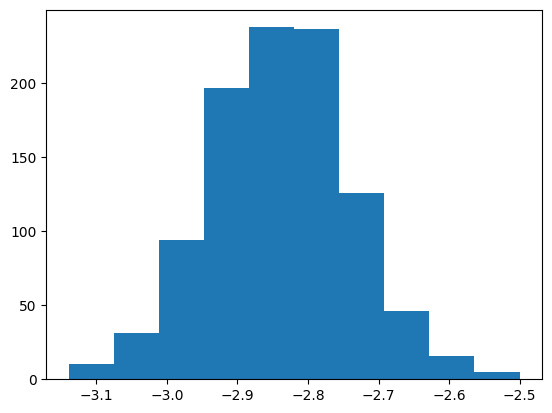

In [221]:
# compute average distance between our models and random initialised
dists = []
for i in range(1000):
    k = random.choice(list(models.keys()))
    model_data = models[k]
    model = networks.CNN()
    model.load_state_dict(torch.load(model_data['fpath']))

    random_model = networks.CNN()
    
    dist = model_distance(model, random_model)
    dists.append(dist)

plt.hist(np.log(dists))

(array([ 11.,  50.,  84., 176., 215., 216., 137.,  73.,  33.,   5.]),
 array([-3.13750073, -3.08240659, -3.02731245, -2.97221832, -2.91712418,
        -2.86203004, -2.8069359 , -2.75184176, -2.69674762, -2.64165349,
        -2.58655935]),
 <BarContainer object of 10 artists>)

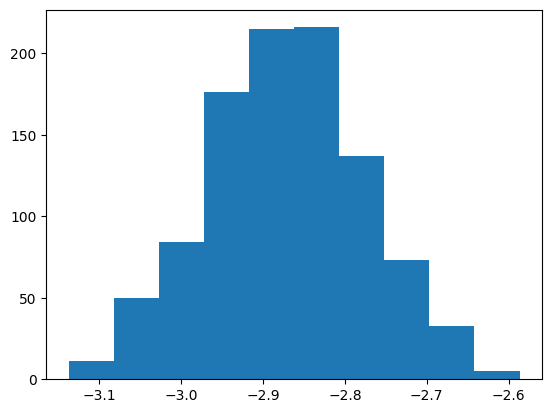

In [222]:
# compute average distance between our models and random initialised
dists = []
for i in range(1000):
    random_model_1 = networks.CNN()
    random_model_2 = networks.CNN()
    
    dist = model_distance(random_model_1, random_model_2)
    dists.append(dist)

plt.hist(np.log(dists))

In [227]:
model_distances = []
accuracy_deltas = []
colours = []
for epoch in [0,1,2,3]:
    for k1, k2 in product(models.keys(), models.keys()):
        m1d = models[k1]
        m2d = models[k2]

        if m1d['config']['epochs'] != epoch or m2d['config']['epochs'] != epoch:
            continue

        m1 = networks.CNN()
        m1.load_state_dict(torch.load(m1d['fpath']))
        m1_acc = m1d['config']['test_accuracy']

        m2 = networks.CNN()
        m2.load_state_dict(torch.load(m2d['fpath']))
        m2_acc = m2d['config']['test_accuracy']


        if m1d['config']['epochs'] == 0:
            colours.append('yellow')
        elif m1d['config']['epochs'] == 1:
            colours.append('red')
        elif m1d['config']['epochs'] == 2:
            colours.append('green')
        else:
            colours.append('blue')

        model_distances.append(np.log(model_distance(m1, m2)))
        accuracy_deltas.append(abs(m1_acc - m2_acc))

/var/folders/kp/slg3jsps2ml2ptbzd0kp6sp40000gn/T/ipykernel_7159/3626164785.py:30: RuntimeWarning: divide by zero encountered in log
  model_distances.append(np.log(model_distance(m1, m2)))


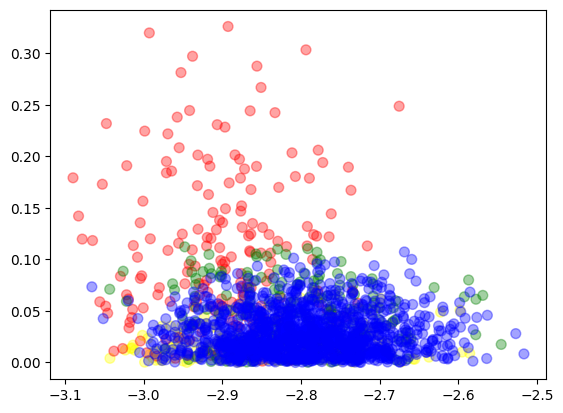

In [228]:
plt.scatter(model_distances, accuracy_deltas, c=colours, s=50, alpha=0.2)

## TSNE Plot

In [241]:
def get_flat_weights(model):
    weights = torch.load(model['fpath'])
    f = networks.CNN()
    f.load_state_dict(weights)
    params = []
    for param in f.parameters():
        params.append(param.reshape(-1).detach())
    return torch.concat(params).numpy()

In [249]:
X = np.array([
    get_flat_weights(model)
    for model in models.values()
])
epoch2c = {
    0: 'yellow',
    1: 'red',
    2: 'green',
    3: 'blue'
}
y = np.array([
    epoch2c[model['config']['epochs']]
    for model in models.values()
])

X_embedded = TSNE(
    n_components=2, learning_rate="auto", init="random", perplexity=3
).fit_transform(X)

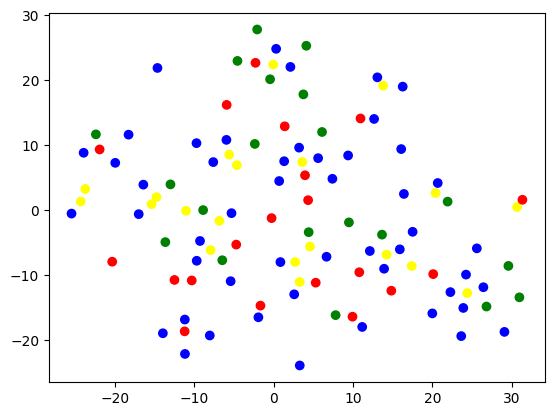

In [250]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y)

## distro comparison

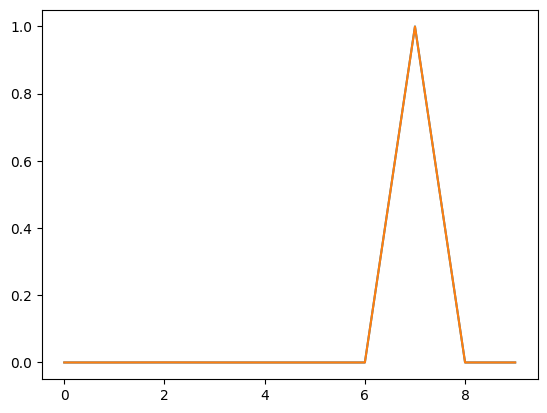

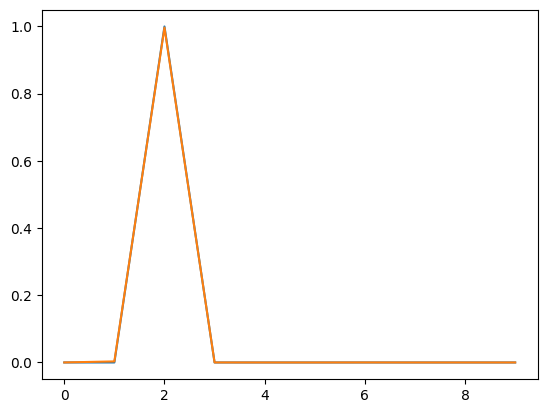

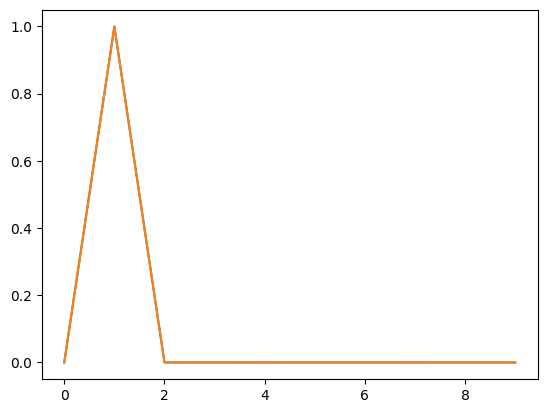

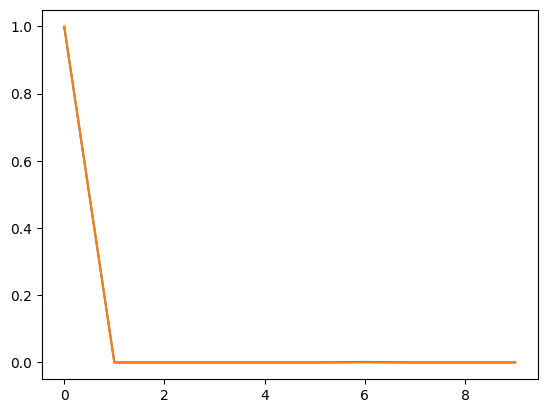

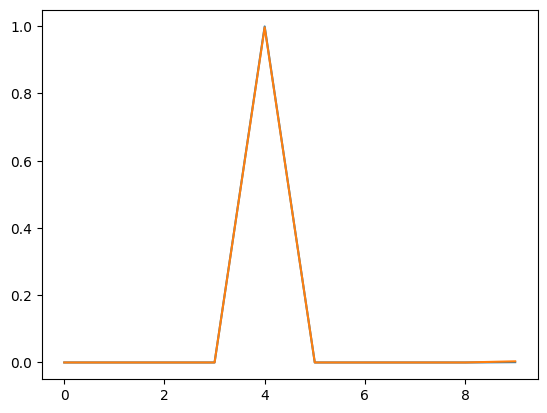

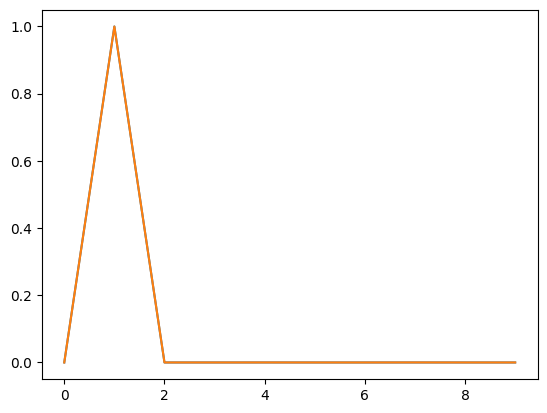

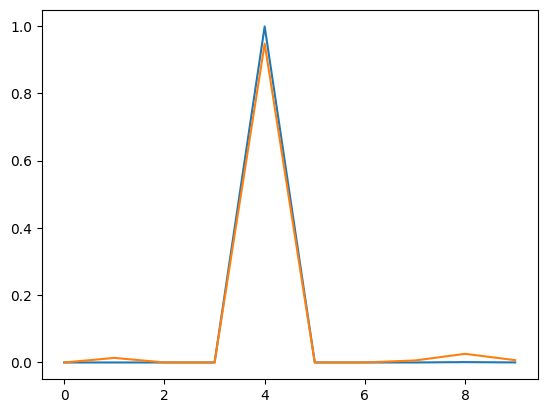

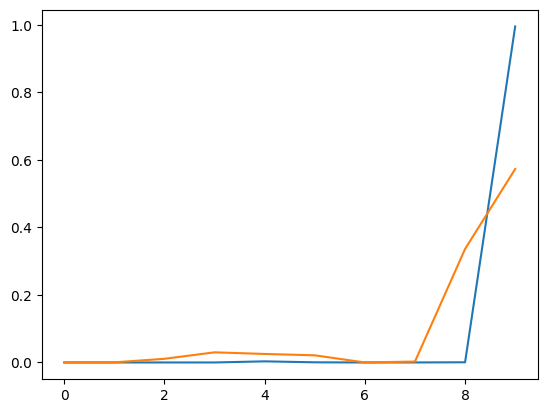

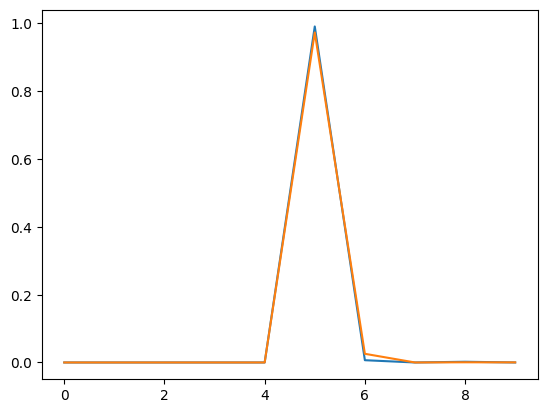

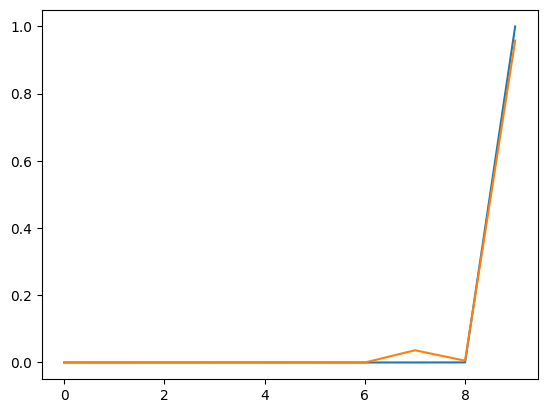

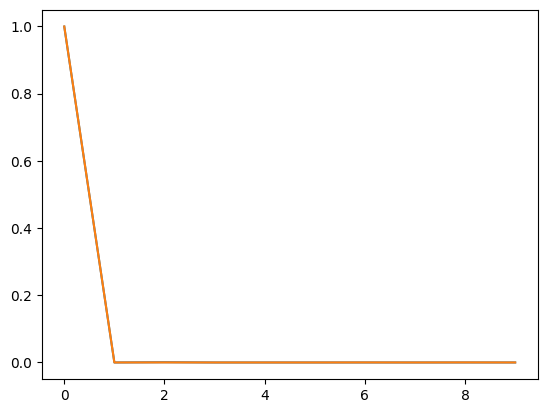

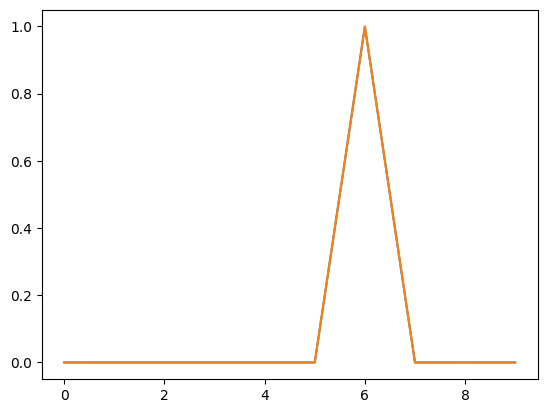

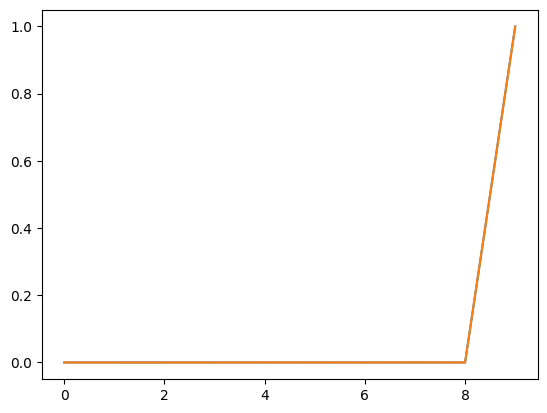

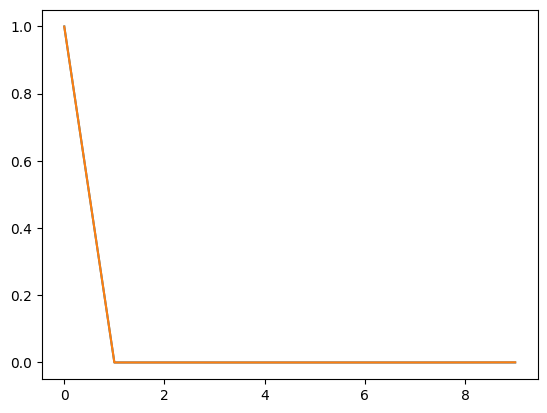

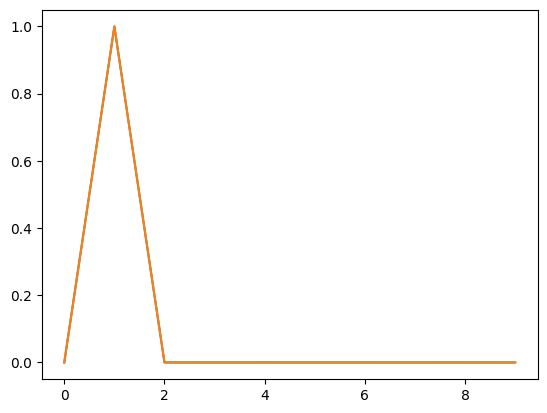

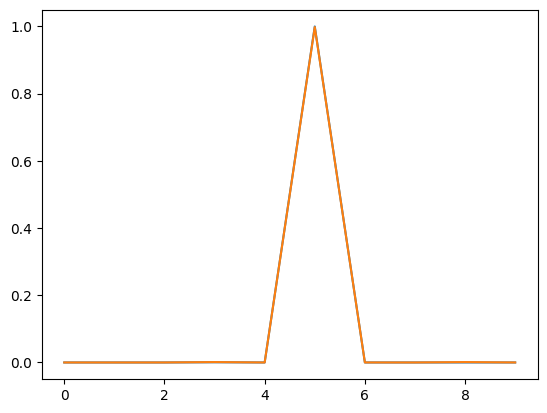

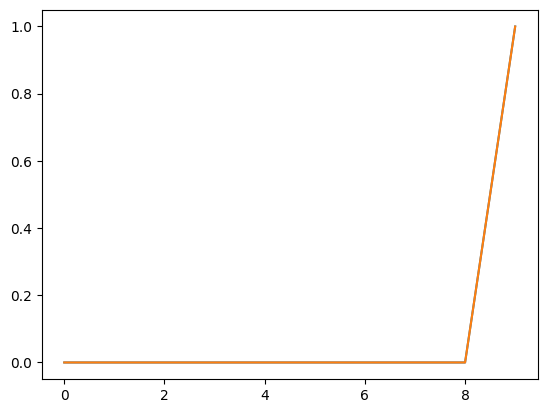

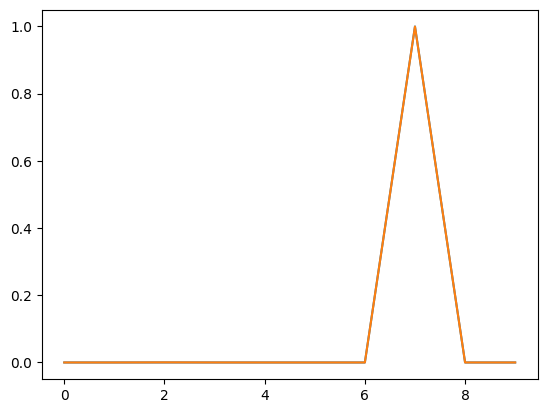

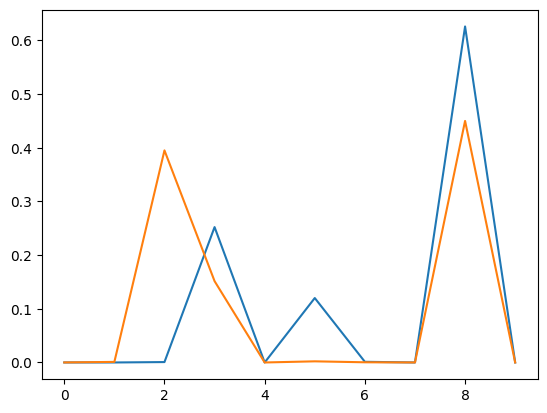

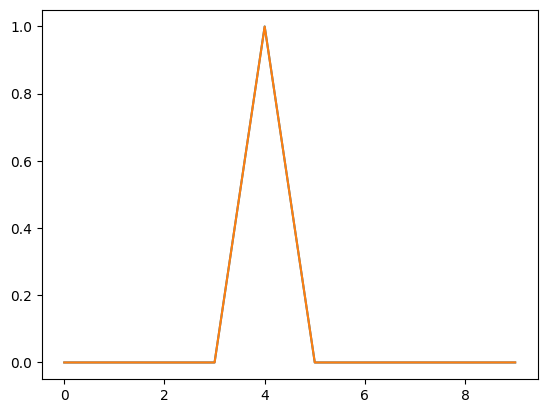

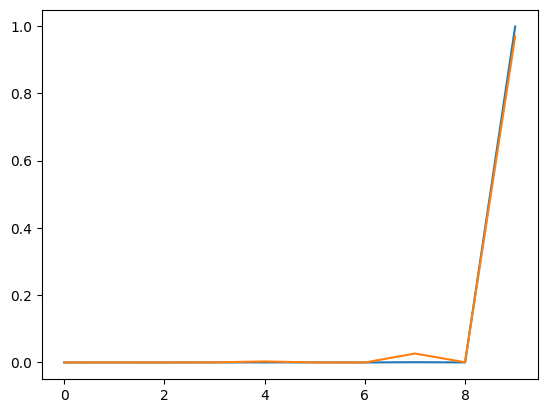

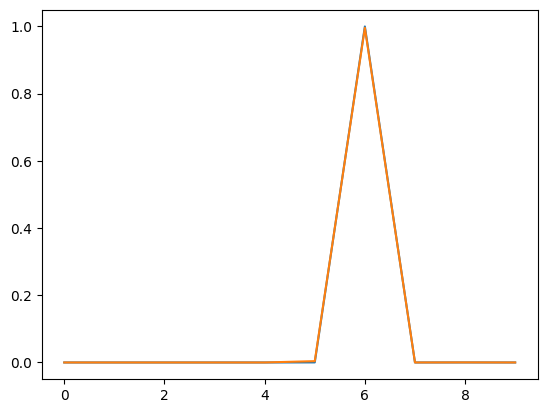

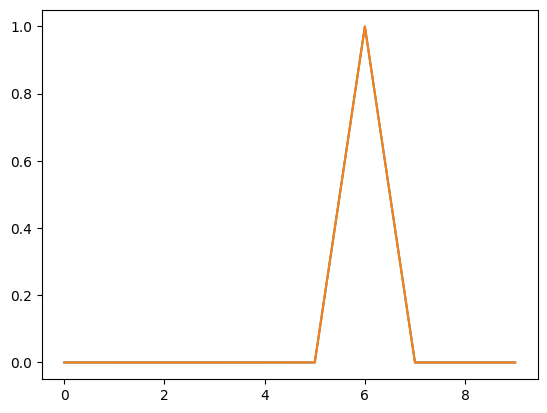

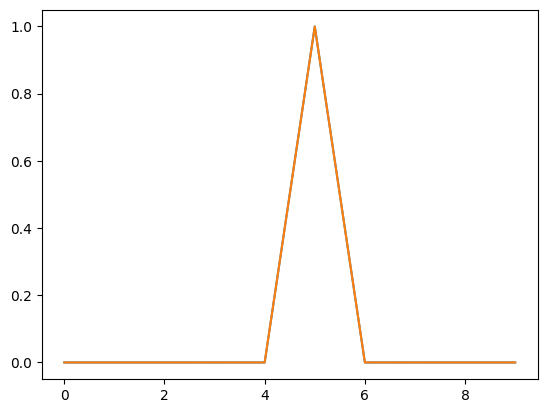

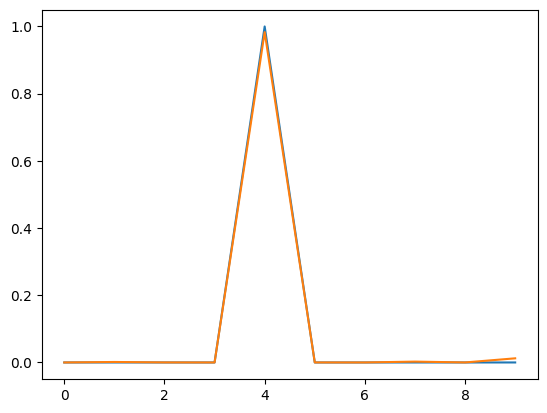

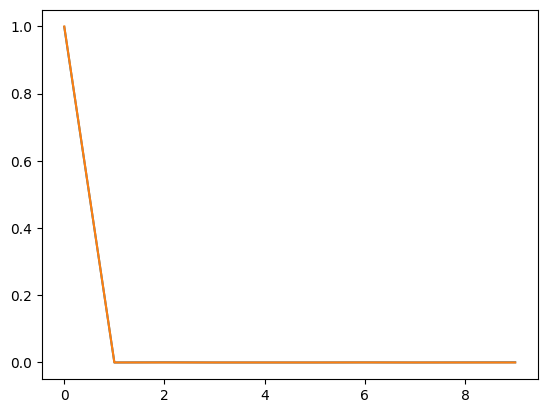

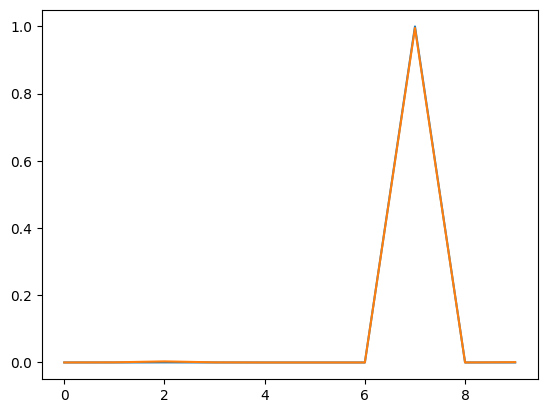

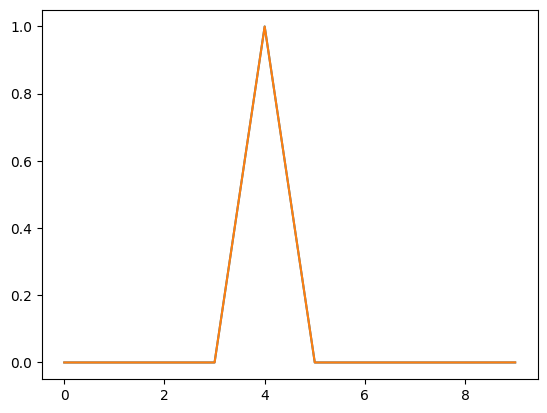

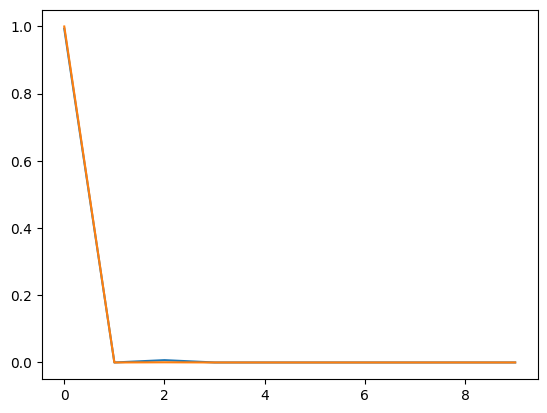

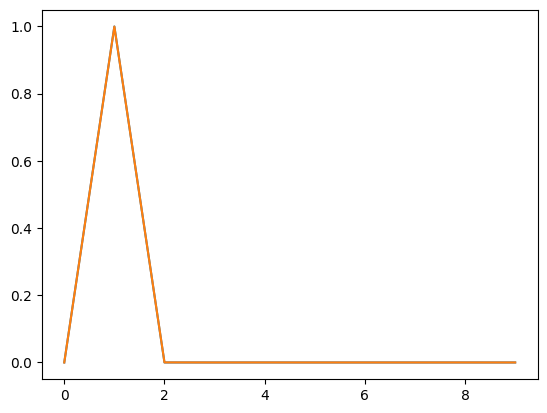

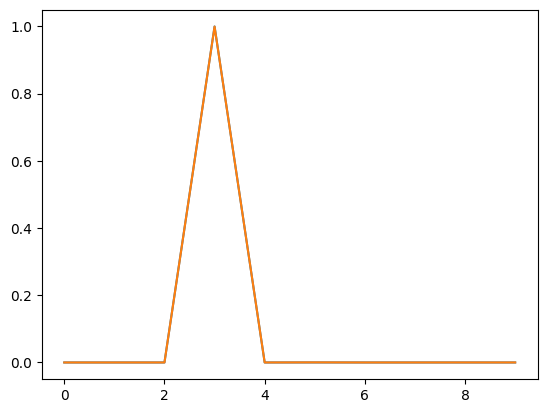

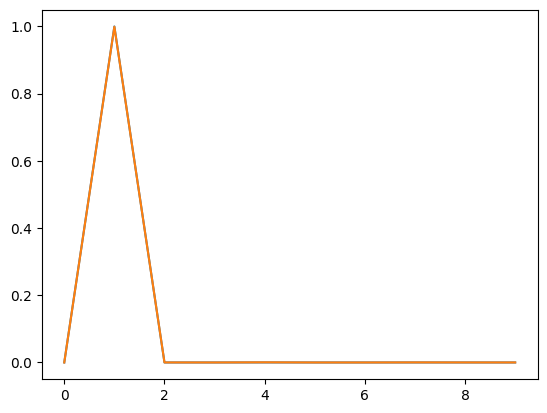

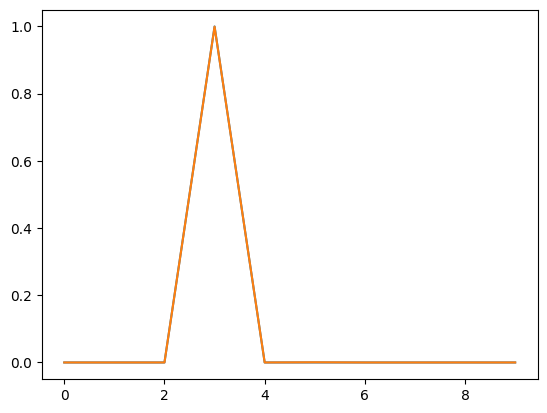

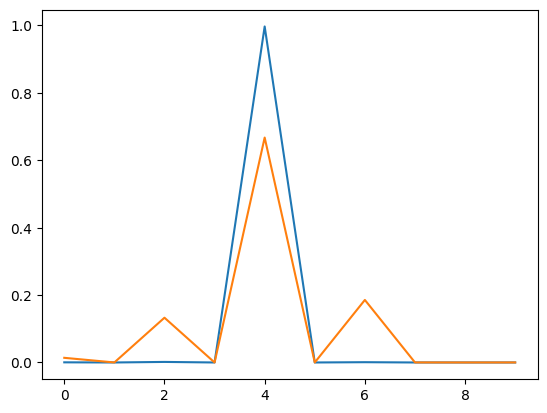

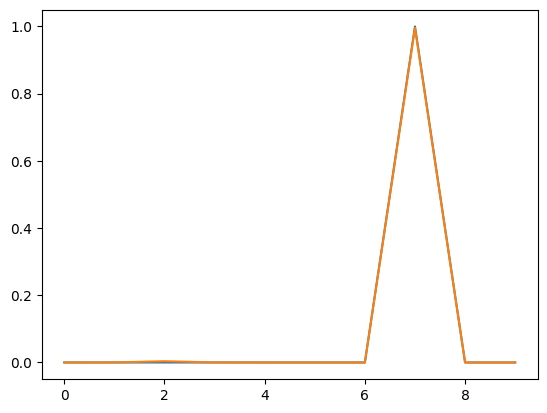

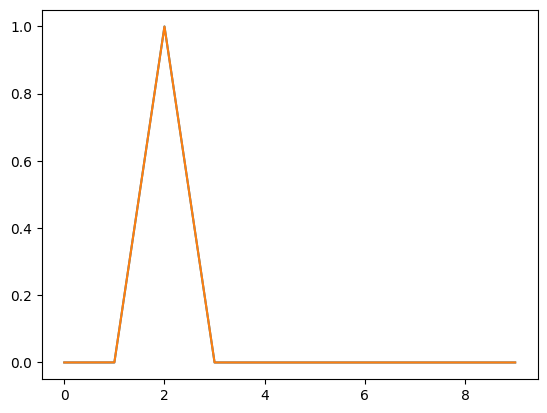

KeyboardInterrupt: 

In [39]:
for x, y_hat in test_loader:
    with torch.no_grad():
        y1 = m1(x)
        y2 = m2(x)
    d1 = torch.nn.functional.softmax(y1, dim=-1)[0]
    d2 = torch.nn.functional.softmax(y2, dim=-1)[0]
    plt.plot(d1)
    plt.plot(d2)
    plt.show()